In [9]:
#import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
import tensorflow as tf

In [10]:
#load data
data = pd.read_csv(r"heart_cleveland_upload.csv")
data.describe()
data.info()
print(data.isnull().sum())
data.columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    int64  
 2   cp         297 non-null    int64  
 3   trestbps   297 non-null    int64  
 4   chol       297 non-null    int64  
 5   fbs        297 non-null    int64  
 6   restecg    297 non-null    int64  
 7   thalach    297 non-null    int64  
 8   exang      297 non-null    int64  
 9   oldpeak    297 non-null    float64
 10  slope      297 non-null    int64  
 11  ca         297 non-null    int64  
 12  thal       297 non-null    int64  
 13  condition  297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB
age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           0
thal         0
conditio

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'condition'],
      dtype='object')

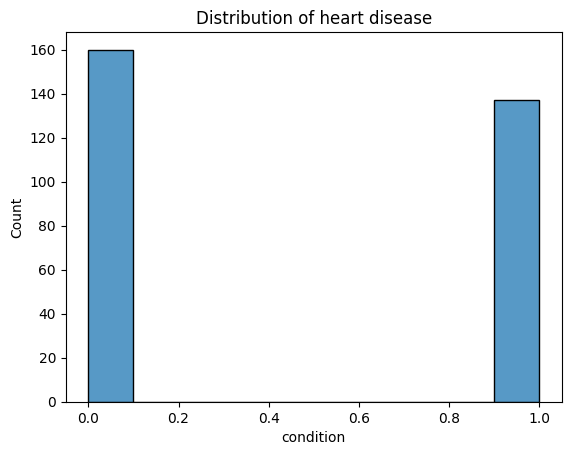

In [11]:
#Data Visualization
plt.Figure(figsize=(1000,500))
sns.histplot(data=data , x="condition")
plt.title("Distribution of heart disease")
plt.show()


In [12]:
#Modeling
x=data.drop(["condition"] , axis=1)
y=data["condition"]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x = scaler.fit_transform(x)

x_train , x_test , y_train , y_test =model_selection.train_test_split(x ,y , test_size=0.2,random_state=42 , stratify=y)
print(x_train.shape , y_train.shape) , x_test , y_test


modeles={"RandomForestClassifier":RandomForestClassifier() , 
         "GradientBoostingClassifier":GradientBoostingClassifier() ,
         "LogisticRegression" :LogisticRegression()}

for name,x in modeles.items():
    x.fit(x_train,y_train)
    y_pre=x.predict(x_train)

    accuracy=accuracy_score(y_train, y_pre)
    print(f"{name}  accuracy score is {accuracy} ")

best_model=RandomForestClassifier()
best_model.fit(x_train,y_train)
y_pre=best_model.predict(x_test)



(237, 13) (237,)
RandomForestClassifier  accuracy score is 1.0 
GradientBoostingClassifier  accuracy score is 0.9957805907172996 
LogisticRegression  accuracy score is 0.8481012658227848 


In [13]:
y_train , y_test= tf.one_hot(y_train , 2) , tf.one_hot(y_test , 2)

model1 = tf.keras.Sequential([
        tf.keras.layers.Input(shape=[13])    ,
        
         tf.keras.layers.Dense(units=64 , activation=tf.nn.leaky_relu),
         
         tf.keras.layers.Dense(units=128 , activation=tf.nn.leaky_relu),
         
         tf.keras.layers.Dense(units=2 , activation=tf.nn.softmax)
])
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,474 (37.01 KB)

 Trainable params: 9,474 (37.01 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model1.compile(optimizer=tf.optimizers.Adam() , loss=tf.losses.BinaryFocalCrossentropy(),metrics=[tf.metrics.BinaryAccuracy])
model1.fit(x=x_train , y=y_train , batch_size=32 , epochs=10 , validation_split=0.1)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - binary_accuracy: 0.6975 - loss: 0.1495 - val_binary_accuracy: 0.8750 - val_loss: 0.0929
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.7876 - loss: 0.1114 - val_binary_accuracy: 0.8750 - val_loss: 0.0879
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.8573 - loss: 0.0952 - val_binary_accuracy: 0.8750 - val_loss: 0.0859
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - binary_accuracy: 0.8360 - loss: 0.1076 - val_binary_accuracy: 0.8750 - val_loss: 0.0872
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - binary_accuracy: 0.8532 - loss: 0.0908 - val_binary_accuracy: 0.8750 - val_loss: 0.0861
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - binary_accuracy: 0.8698 - loss: 0.0883 - val_binary_accuracy: 0.8750 - val_loss: 0.0856
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - binary_accuracy: 0.8541 - loss: 0.0816 - val_binary_accuracy: 0.8750 - val_loss: 0.0858
Epoch 8/10
7/7 ━━━━━━━━━━━━

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,090 (285.51 KB)

 Trainable params: 73,090 (285.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - categorical_accuracy: 0.6475 - loss: 0.6281 - val_categorical_accuracy: 0.9167 - val_loss: 0.3971
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.8422 - loss: 0.4199 - val_categorical_accuracy: 0.9167 - val_loss: 0.2958
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.8543 - loss: 0.3371 - val_categorical_accuracy: 0.9167 - val_loss: 0.2765
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.8399 - loss: 0.3731 - val_categorical_accuracy: 0.9167 - val_loss: 0.2667
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.8349 - loss: 0.3640 - val_categorical_accuracy: 0.8750 - val_loss: 0.2511
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.8438 - loss: 0.3493 - val_categorical_accuracy: 0.9167 - val_loss: 0.2441
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.8666 - loss: 0.3333 - val_categ

<Axes: >

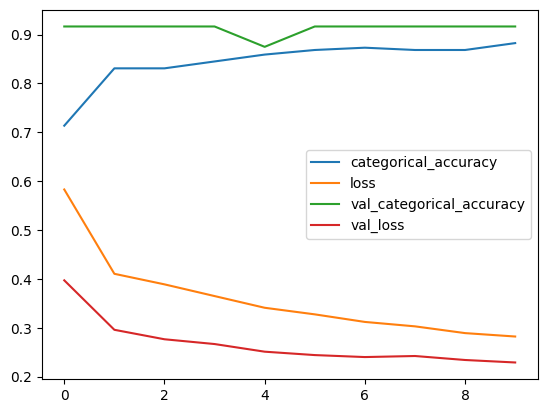

In [15]:
input_shape=x_train.shape[1]


input_layer=tf.keras.layers.Input(shape=(input_shape,))  
dense_layer1=tf.keras.layers.Dense(units=512 , activation=tf.nn.leaky_relu)(input_layer)  
dense_layer2= tf.keras.layers.Dense(units=128 , activation=tf.nn.leaky_relu)(dense_layer1)
output_layer= tf.keras.layers.Dense(units=2 , activation=tf.nn.sigmoid)(dense_layer2)
model=tf.keras.Model(inputs=[input_layer] , outputs=[output_layer])

model.summary()

model.compile(optimizer=tf.optimizers.Adam() , loss=tf.losses.CategoricalCrossentropy()
               , metrics=[tf.metrics.CategoricalAccuracy()])

model.fit(x=x_train , y=y_train , epochs=10 , validation_split=0.1 , batch_size=32)

df = pd.DataFrame(model.history.history)
df.plot()

In [16]:
import pickle
filename='heart_disease_V2.sav'
pickle.dump(best_model , open(filename , 'wb') )